In [20]:
import networkx as nx
import os
from pathlib import Path
import pandas as pd
import numpy as np
import math
from scipy.stats import linregress  # added: import linregress directly to avoid name collision
import re  # added: needed by clean_str

In [ ]:
# setup

xferpath = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\cleaned")
recpath = Path(r"C:\Users\User\Documents\cfb project\data\recruiting")
xferfiles = {}
recfiles = {}

for file_path in xferpath.glob('*.graphml'):
    name = file_path.stem
    G_x = nx.read_graphml(file_path)
    xferfiles[name] = G_x

for file_path in recpath.glob('*.graphml'):
    name = file_path.stem
    G_r = nx.read_graphml(file_path)
    recfiles[name] = G_r

print(f"\nSuccessfully loaded {len(xferfiles)} files from xfer and {len(recfiles)} files from rec.")



Successfully loaded 5 files from xfer and 27 files from rec.


In [ ]:
# degree analysis OLD (xfer)

import networkx as nx
import pandas as pd
import numpy as np
from pathlib import Path

# Load cleaned transfer portal data
xferpath = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\cleaned")
xferfiles = {}

for file_path in xferpath.glob('*_cleaned.graphml'):
    name = file_path.stem.replace('_cleaned', '')
    G = nx.read_graphml(file_path)
    xferfiles[name] = G

print(f"Loaded {len(xferfiles)} transfer portal files\n")

# ============================================
# CALCULATE NPV WITH UNCERTAINTY BOUNDS
# ============================================

def nd_npv_rating(G):
    """
    Calculate NPV for each school with uncertainty bounds
    based on missing data.
    """
    school_stats = {}
    
    for node in G.nodes():
        in_transfers = []
        out_transfers = []
        in_missing = 0
        out_missing = 0
        
        # Incoming transfers
        for pred in G.predecessors(node):
            for key, data in G[pred][node].items():
                rating = data.get('ratings', '')
                if rating and rating not in ['', '0.0', 'None']:
                    in_transfers.append(float(rating))
                else:
                    in_missing += 1
        
        # Outgoing transfers
        for succ in G.successors(node):
            for key, data in G[node][succ].items():
                rating = data.get('ratings', '')
                if rating and rating not in ['', '0.0', 'None']:
                    out_transfers.append(float(rating))
                else:
                    out_missing += 1
        
        # Calculate NPV components
        in_sum = sum(in_transfers)
        out_sum = sum(out_transfers)
        npv = in_sum - out_sum
        
        # Calculate uncertainty bounds (assume missing values could be ±0.1)
        # Best case: missing incoming are high (0.95), missing outgoing are low (0.75)
        # Worst case: missing incoming are low (0.75), missing outgoing are high (0.95)
        best_case_npv = (in_sum + in_missing * 0.95) - (out_sum + out_missing * 0.75)
        worst_case_npv = (in_sum + in_missing * 0.75) - (out_sum + out_missing * 0.95)
        
        uncertainty = (best_case_npv - worst_case_npv) / 2
        
        school_stats[node] = {
            'npv':round(npv,2),
            'assumed_npv': round((best_case_npv + worst_case_npv) / 2, 2) if (in_missing + out_missing) > 0 else round(npv,2),
            'in_wt': round(in_sum,2),
            'out_wt': round(out_sum,2),
            'net_degree': len(in_transfers) - len(out_transfers),
            'in_count': len(in_transfers),
            'out_count': len(out_transfers),
            'in_missing': in_missing,
            'out_missing': out_missing,
            'total_missing': in_missing + out_missing,
            'uncertainty': round(uncertainty,2),
            'high_range_npv': round(best_case_npv,2),
            'low_range_npv': round(worst_case_npv,2)
        }
    
    return school_stats

Loaded 5 transfer portal files



In [16]:
# degree analysis with PPA

# Load Data
xferpath = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\cleaned")
xferfiles = {}
for file_path in xferpath.glob('*_cleaned.graphml'):
    name = file_path.stem.replace('_cleaned', '')
    # Open with latin1 to avoid encoding errors
    with open(file_path, 'r', encoding='latin1') as f:
        xferfiles[name] = nx.read_graphml(f)

# Load performance with latin1 to handle special characters
performance_df = pd.read_csv(
    r"C:\Users\User\Documents\cfb project\data\supplemental\player_performance.csv", 
    encoding='latin1'
)

# ============================================
# HELPER: NAME NORMALIZATION
# ============================================
def clean_str(s):
    """
    Standardizes names for matching:
    'Caleb Williams ' -> 'calebwilliams'
    'J.J. McCarthy' -> 'jjmccarthy'
    """
    if not isinstance(s, str): return ""
    # Remove punctuation, spaces, and make lowercase
    return re.sub(r'[^a-z0-9]', '', str(s).lower())

# ============================================
# PART A: DERIVE CONVERSION FORMULA (Using Name Matching)
# ============================================

print("Analyzing relationship between Ratings and PPA (Name Match Mode)...")

# 1. Prepare Performance Lookup
# Key: (clean_name, clean_team, year) -> PPA
perf_lookup = {}
for _, row in performance_df.iterrows():
    c_name = clean_str(row['name'])
    c_team = clean_str(row['team'])
    year = row['season']
    ppa = row['totalPPA_all']
    
    # Store in dictionary
    perf_lookup[(c_name, c_team, year)] = ppa

# 2. Harvest Ratings & PPA from Graphs
reg_data = []

for name, G in xferfiles.items():
    year = int(name.replace('transfer_portal_', '').replace('recruiting_network_', '')) # Extract year
    prev_season = year - 1
    
    edges = G.edges(data=True, keys=True) if isinstance(G, nx.MultiDiGraph) else G.edges(data=True)
    
    for u, v, *_, data in edges:
        # Get raw data
        raw_name = data.get('player', data.get('players', ''))
        rating = data.get('ratings', data.get('rating'))
        
        # Handle list-strings if present
        if isinstance(raw_name, str) and '|' in raw_name: raw_name = raw_name.split(' | ')[0]
        if isinstance(rating, str) and '|' in rating: rating = rating.split(' | ')[0]
        
        if not raw_name or not rating:
            continue
            
        # MATCHING LOGIC
        # u is the Source Node (Previous School)
        # v is the Target Node (New School)
        # We want stats from the Previous School (u) in the Previous Season
        
        c_name = clean_str(raw_name)
        c_team = clean_str(u) # The previous school
        
        # Look for PPA
        found_ppa = perf_lookup.get((c_name, c_team, prev_season))
        
        if found_ppa is not None:
            try:
                r_float = float(rating)
                if r_float > 0 and -20 < found_ppa < 100: # Filter outliers
                    reg_data.append({'rating': r_float, 'ppa': found_ppa})
            except:
                pass

# 3. Calculate Regression
df_reg = pd.DataFrame(reg_data)

if len(df_reg) > 0:
    # changed: call linregress(...) directly (we imported it above)
    slope, intercept, r_value, p_value, std_err = linregress(df_reg['rating'], df_reg['ppa'])
    print(f"✓ Matched {len(df_reg)} players by Name/Team.")
    print(f"✓ Formula: PPA = ({slope:.2f} * Rating) + ({intercept:.2f})")
else:
    print("⚠ Could not match any players! Check team names in graph vs CSV.")
    slope, intercept = 25.0, 0 # Fallback default

# ============================================
# PART B: CALCULATE NPV WITH 3-TIER UNCERTAINTY
# ============================================

def nd_npv_ppa(G, year, slope, intercept, std_err):
    school_stats = {}
    prev_season = int(year) - 1
    
    # Uncertainty Constants
    # 1. Regression Error: How much our formula might be off (95% confidence approx = 2 * std_err)
    REGRESSION_RANGE = std_err * 2 if std_err else 5.0
    
    # 2. Total Mystery: Range for players with NO data (Rating or PPA)
    # Conservative estimate: 0 (bench) to 10 (decent contributor)
    MYSTERY_LOW = 0.0
    MYSTERY_HIGH = 10.0
    
    for node in G.nodes():
        # Trackers for "Expected" values
        in_val = 0
        out_val = 0
        
        # Trackers for "Variance" (High/Low potential)
        in_var_high = 0
        in_var_low = 0
        out_var_high = 0
        out_var_low = 0
        
        # Counters
        in_count = 0
        out_count = 0
        
        # --- Edge Processor ---
        def get_player_val_range(u, v):
            edges = G[u][v].items()
            
            # Returns: (expected_val, max_upside, max_downside)
            values = []
            
            for k, data in edges:
                raw_name = data.get('player', data.get('players', ''))
                rating = data.get('ratings', data.get('rating'))
                
                # Cleaning
                if isinstance(raw_name, str) and '|' in raw_name: raw_name = raw_name.split(' | ')[0]
                if isinstance(rating, str) and '|' in rating: rating = rating.split(' | ')[0]

                # 1. CHECK FOR PROVEN PPA (Tier 1)
                c_name = clean_str(raw_name)
                c_prev_team = clean_str(u) 
                found_ppa = perf_lookup.get((c_name, c_prev_team, prev_season))
                
                if found_ppa is not None:
                    # PROVEN: No uncertainty. Value is exactly what it is.
                    val = float(found_ppa)
                    values.append((val, 0, 0)) # (val, +0, -0)
                    continue
                
                # 2. CHECK FOR RATING PROJECTION (Tier 2)
                r_float = 0.0
                try:
                    r_float = float(rating)
                except:
                    pass
                
                if r_float > 0:
                    # PROJECTED: Value is Formula ± Regression Error
                    projected = (r_float * slope) + intercept
                    values.append((projected, REGRESSION_RANGE, REGRESSION_RANGE))
                    continue
                    
                # 3. TOTAL MYSTERY (Tier 3)
                # No stats, no rating.
                # Assume base value is low (2.0), but variance is high.
                values.append((2.0, MYSTERY_HIGH - 2.0, 2.0 - MYSTERY_LOW))
            
            return values

        # Process Incoming
        for pred in G.predecessors(node):
            results = get_player_val_range(pred, node)
            for base, up, down in results:
                in_val += base
                in_var_high += up
                in_var_low += down
                in_count += 1

        # Process Outgoing
        for succ in G.successors(node):
            results = get_player_val_range(node, succ)
            for base, up, down in results:
                out_val += base
                out_var_high += up
                out_var_low += down
                out_count += 1
        
        # --- CALCULATE BOUNDS ---
        # NPV = In - Out
        
        # Expected NPV
        npv_expected = in_val - out_val
        
        # Best Case NPV: Incoming perform at Ceiling, Outgoing perform at Floor
        # (We lost "bad" players and gained "great" players)
        in_ceiling = in_val + in_var_high
        out_floor = out_val - out_var_low
        npv_best_case = in_ceiling - out_floor
        
        # Worst Case NPV: Incoming perform at Floor, Outgoing perform at Ceiling
        # (We gained "busts" and lost "stars")
        in_floor = in_val - in_var_low
        out_ceiling = out_val + out_var_high
        npv_worst_case = in_floor - out_ceiling
        
        uncertainty_range = (npv_best_case - npv_worst_case) / 2
        
        school_stats[node] = {
            'npv_actual': round(npv_expected, 2),
            'npv_assumed': round((npv_best_case + npv_worst_case) / 2, 2) if (in_count + out_count) > 0 else round(npv_expected, 2),
            'npv_high': round(npv_best_case, 2),
            'npv_low': round(npv_worst_case, 2),
            'uncertainty': round(uncertainty_range, 2),
            'net_degree': in_count - out_count
        }
        
    return school_stats

# ============================================
# EXECUTION
# ============================================

all_results = []
for name, G in xferfiles.items():
    year_str = name.replace('transfer_portal_', '').replace('recruiting_network_', '')
    try:
        # Pass std_err from the regression earlier
        stats = nd_npv_ppa(G, year_str, slope, intercept, std_err)
        
        df = pd.DataFrame.from_dict(stats, orient='index')
        df.index.name = 'school'
        df = df.reset_index()
        df['year'] = name
        all_results.append(df)
    except ValueError:
        pass

final_df = pd.concat(all_results, ignore_index=True)
print(final_df[['year', 'school', 'npv_actual', 'npv_assumed', 'npv_low', 'npv_high']].head(10))



Analyzing relationship between Ratings and PPA (Name Match Mode)...
✓ Matched 1848 players by Name/Team.
✓ Formula: PPA = (191.48 * Rating) + (-145.32)
                   year                  school  npv_actual  npv_assumed  \
0  transfer_portal_2021                Missouri     -189.89      -189.89   
1  transfer_portal_2021                    UTSA       80.35        83.35   
2  transfer_portal_2021          Arkansas State       43.38        43.38   
3  transfer_portal_2021           Southern Miss        8.81         8.81   
4  transfer_portal_2021                   Miami      -12.80       -12.80   
5  transfer_portal_2021                 Wyoming        0.00         0.00   
6  transfer_portal_2021        Eastern Michigan      -29.13       -26.13   
7  transfer_portal_2021              Vanderbilt     -127.51      -124.51   
8  transfer_portal_2021                   Tulsa       15.06        15.06   
9  transfer_portal_2021  Missouri Western State       -2.00        -5.00   

   npv_low 

In [18]:
# save results (1 for old, 2 for new, 0 for neither)
switch = 2
if switch == 1: # prevent accidental overwrite
    # calculate for all years
    for name, g in xferfiles.items():
        
        year = int(name.split('_')[-1])
        print(f"Calculating NPV for {year}...")
        rstats = nd_npv_rating(g, year)

        # Convert to DataFrame
        results_df = pd.DataFrame.from_dict(rstats, orient='index')
        results_df['school'] = results_df.index
        results_df = results_df.sort_values('npv', ascending=False)

        # save to csv
        output_path = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\analysis") / f"degree_analysis_{year}.csv"
        results_df.to_csv(output_path, index=False)

    print('NPV by rating successful')

if switch == 2:
    output_path = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\analysis") / f"degree_analysis_ppa.csv"
    final_df.to_csv(output_path, index=False)

    print('NPV by PPA successful')

if switch == 0:
    print("Switch is off; operation skipped.")

NPV by PPA successful


LinregressResult(slope=np.float64(0.034866207509447994), intercept=np.float64(-6.57439487923603e-06), rvalue=np.float64(0.7154857571790586), pvalue=np.float64(8.96707387492128e-250), stderr=np.float64(0.0008540579378030059), intercept_stderr=np.float64(0.08383225504834048))


<Axes: xlabel='net_degree', ylabel='npv_actual'>

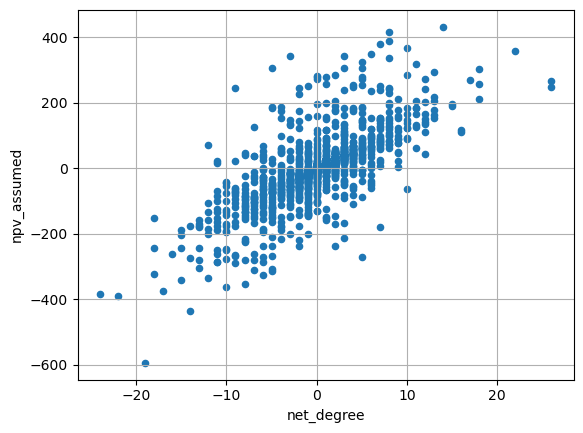

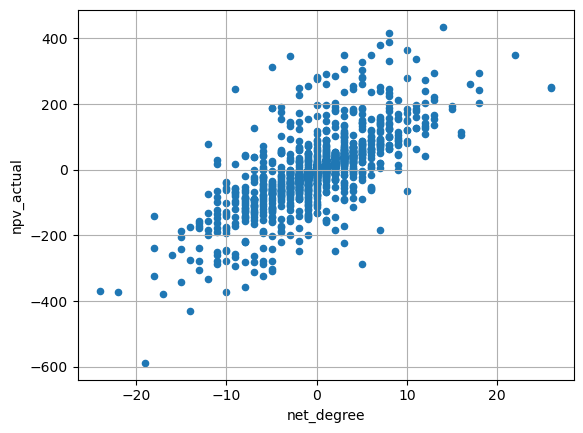

In [23]:
# distributions and summary stats

final_df.plot.scatter(y='npv_assumed', x='net_degree', grid=True)
print(linregress(final_df['npv_assumed'], final_df['net_degree']))
final_df.plot.scatter(y='npv_actual', x='net_degree', grid=True)
#results_df.plot.scatter(y='assumed_npv', x='net_degree', grid=True)